In [1]:
import matplotlib
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
import warnings #to remove the warnings
import random
import sys
sys.path.append('../../_hepers_')
from genNewVals import generateNewFeatureValMultiple
from subsampleData import subsample
from models import trainModels
from genFillNulls import *
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler





In [2]:
def trainF1CrossValModels(X, y, numFolds):
    nb = GaussianNB()
    nbScores = cross_val_score(nb, X, y, cv=numFolds, scoring='f1')
    print('Completed Naive Bayes')
    logisticClassifier = LogisticRegression()
    logScores = cross_val_score(logisticClassifier, X, y, cv=numFolds, scoring='f1')
    print('Completed Logistic Regression')
    svclassifier = SVC(kernel='linear', max_iter = 5000000)
    svmScores = cross_val_score(svclassifier, X, y, cv=numFolds, scoring='f1')
    print('Completed SVM')
    clf = DecisionTreeClassifier(random_state = 42)
    dtScrores = cross_val_score(clf, X, y, cv=numFolds, scoring='f1')
    print('Completed Decision Tree')
    votingCl = VotingClassifier(
                estimators =    [('gnb', GaussianNB()),
                                ('lr',  LogisticRegression()),
                                ('svm', SVC(kernel='linear', max_iter = 5000000)),
                                ('dtc', DecisionTreeClassifier(random_state=42))], 
                voting='hard')
    voteScores = cross_val_score(votingCl, X, y, cv=numFolds, scoring='f1')
    print('Completed Voting Classification')
    return nbScores, logScores, svmScores, dtScrores, voteScores

def generateSupplementalData(X_train, y_train, numBenign = 0, numMalig = 0):
    trainingSet = X_train.copy()
    trainingSet['Diagnosis'] = y_train
    arr2D = trainingSet.to_numpy()
    columnIndex = -1
    sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
    numZeros = list(sortedArr[:, columnIndex]).count(0)
    benignDF, malignantDF = pd.DataFrame(sortedArr[0:numZeros]), pd.DataFrame(sortedArr[numZeros:])
    benignDF.columns, malignantDF.columns = trainingSet.columns, trainingSet.columns
    numBenignNeeded = numBenign - benignDF.shape[0]
    numMaligNeeded = numMalig - malignantDF.shape[0]

    #Storing all Raw Benign Data to Later be Merged with Synthetic
    preExistingBenign = []
    for index, row in benignDF.iterrows():
        preExistingBenign.append(list(row))
    preExistingBenign = np.array(preExistingBenign)
    
    #Storing all Raw Malignant Data to Later be Merged with Synthetic
    preExistingMalig = []
    for index, row in malignantDF.iterrows():
        preExistingMalig.append(list(row))
    preExistingMalig = np.array(preExistingMalig)

    #Generating New Data
    benignPatients = []
    for col in benignDF.columns:
        benignPatients.append(generateNewFeatureValMultiple(benignDF, col, 25, numBenignNeeded))
    benignPatients = np.array(benignPatients).T
    malignangPatients = []
    for col in malignantDF.columns:
        malignangPatients.append(generateNewFeatureValMultiple(malignantDF, col, 25, numMaligNeeded))
    malignangPatients = np.array(malignangPatients).T

    #Combining Real Data and Synthetic Data, or Only using Real Data in the case of majority class
    if np.array(benignPatients).shape[0] > 0:
        benignPatients = np.vstack((preExistingBenign, np.array(benignPatients)))
    else:
        benignPatients = preExistingBenign
    if np.array(malignangPatients).shape[0] > 0:
        malignangPatients = np.vstack((preExistingMalig, np.array(malignangPatients)))
    else:
        benignPatients = preExistingBenign
    jointArray = np.vstack((benignPatients,malignangPatients))
    finalDataset = pd.DataFrame(jointArray, columns = benignDF.columns) 

    #Reporting Summary
    print('Final Dataset Composition: {}'.format(finalDataset.shape))
    print(' - Benign:')
    print('   -   New Benign Instances Created: {}'.format(numBenignNeeded))
    print('   -   Old Benign Instances Used: {}'.format(preExistingBenign.shape[0]))
    print(' - Malignant:')
    print('   -   New Malignant Instances Created: {}'.format(numMaligNeeded))
    print('   -   Old Malignant Instances Used: {}'.format(preExistingMalig.shape[0]))
    return finalDataset

def printOutputs(naiveBayesScore, LogScore, SVMScore, DTScore, VoteScore):
    print('NB Mean Scores: {}'.format(np.mean(naiveBayesScore)))
    print('LR Mean Scores: {}'.format(np.mean(LogScore)))
    print('SVM Mean Scores: {}'.format(np.mean(SVMScore)))
    print('DT Mean Scores: {}'.format(np.mean(DTScore)))
    print('VC Mean Scores: {}'.format(np.mean(VoteScore)))

In [3]:
random.seed(42)
np.random.seed(42)
raw_df = pd.read_csv('../../../Wisconsin_Database/breast-cancer-wisconsin.data', header=None)
cols = ['ID', 'Thickness', 'SizeUniformity', 'ShapeUniformity', 'Adhesion', 'Size', 'BareNuclei', 'Bland Chromatin', 'Nucleoli', 'Mitoses', 'Diagnosis']
raw_df.columns = cols
raw_df['Diagnosis'] = raw_df['Diagnosis'].map(
                   {2:0,4:1})

temp = []
for index, row in raw_df.iterrows():
    if '?' not in row.values:
        temp.append(row)
        
df = pd.DataFrame(np.array(temp), columns=cols)
df['BareNuclei'] = df['BareNuclei'].astype(np.int)
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.int)


X = df[cols[1:-1]]
y = df[cols[-1]]
subSample = pd.DataFrame(subsample(X, y, 20000, 60))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
numClassSamples = len(y) - sum(y)
finalDataset = generateSupplementalData(X, y, numBenign = numClassSamples, numMalig = numClassSamples)

X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]
augNBWBC, augLogWBC, augSVMWBC, auglDTWBC, augVoteWBC = trainF1CrossValModels(X, y, 10)
printOutputs(augNBWBC, augLogWBC, augSVMWBC, auglDTWBC, augVoteWBC)

(683, 11)
Final Dataset Composition: (888, 10)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 444
 - Malignant:
   -   New Malignant Instances Created: 384
   -   Old Malignant Instances Used: 60
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.9749558584931475
LR Mean Scores: 0.9763606466439386
SVM Mean Scores: 0.9789460780765127
DT Mean Scores: 0.9650305241865345
VC Mean Scores: 0.978633393054616


In [4]:
random.seed(42)
np.random.seed(42)
raw_df = pd.read_csv('../../../Wisconsin_Database/breast-cancer-wisconsin.data', header=None)
cols = ['ID', 'Thickness', 'SizeUniformity', 'ShapeUniformity', 'Adhesion', 'Size', 'BareNuclei', 'Bland Chromatin', 'Nucleoli', 'Mitoses', 'Diagnosis']
raw_df.columns = cols
raw_df['Diagnosis'] = raw_df['Diagnosis'].map(
                   {2:0,4:1})

temp = []
for index, row in raw_df.iterrows():
    if '?' not in row.values:
        temp.append(row)
        
df = pd.DataFrame(np.array(temp), columns=cols)
df['BareNuclei'] = df['BareNuclei'].astype(np.int)
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.int)


X = df[cols[1:-1]]
y = df[cols[-1]]
subSample = pd.DataFrame(subsample(X, y, 20000, 60))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]


rawNBWBC, rawLogWBC, rawSVMWBC, rawlDTWBC, rawVoteWBC = trainF1CrossValModels(X, y, 10)
printOutputs(rawNBWBC, rawLogWBC, rawSVMWBC, rawlDTWBC, rawVoteWBC)


(683, 11)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.8352951950010773
LR Mean Scores: 0.8727156177156177
SVM Mean Scores: 0.8815068265068267
DT Mean Scores: 0.8570745920745919
VC Mean Scores: 0.8727156177156177


In [5]:
random.seed(42)
np.random.seed(42)
raw_df = pd.read_csv('../../../Wisconsin_Database/breast-cancer-wisconsin.data', header=None)
cols = ['ID', 'Thickness', 'SizeUniformity', 'ShapeUniformity', 'Adhesion', 'Size', 'BareNuclei', 'Bland Chromatin', 'Nucleoli', 'Mitoses', 'Diagnosis']
raw_df.columns = cols
raw_df['Diagnosis'] = raw_df['Diagnosis'].map(
                   {2:0,4:1})

temp = []
for index, row in raw_df.iterrows():
    if '?' not in row.values:
        temp.append(row)
        
df = pd.DataFrame(np.array(temp), columns=cols)
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.int)
X = df[cols[1:-1]]
y = df[cols[-1]]
print('Percent Malignant: {}'.format(sum(y)/len(y)))
subSample = pd.DataFrame(subsample(X, y, 20000, 60))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
print('Percent Malignant: {}'.format(sum(y)/len(y)))
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
print('Percent Malignant: {}'.format(sum(y)/len(y)))

smoteNBWBC, smoteLogWBC, smoteSVMWBC, smotelDTWBC, smoteVoteWBC = trainF1CrossValModels(X, y, 10)
printOutputs(smoteNBWBC, smoteLogWBC, smoteSVMWBC, smotelDTWBC, smoteVoteWBC)


(683, 11)
Percent Malignant: 0.34992679355783307
Percent Malignant: 0.11904761904761904
Percent Malignant: 0.5
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.9613032107950389
LR Mean Scores: 0.971927701425958
SVM Mean Scores: 0.9744608515605655
DT Mean Scores: 0.9797477678376556
VC Mean Scores: 0.9765473511022928


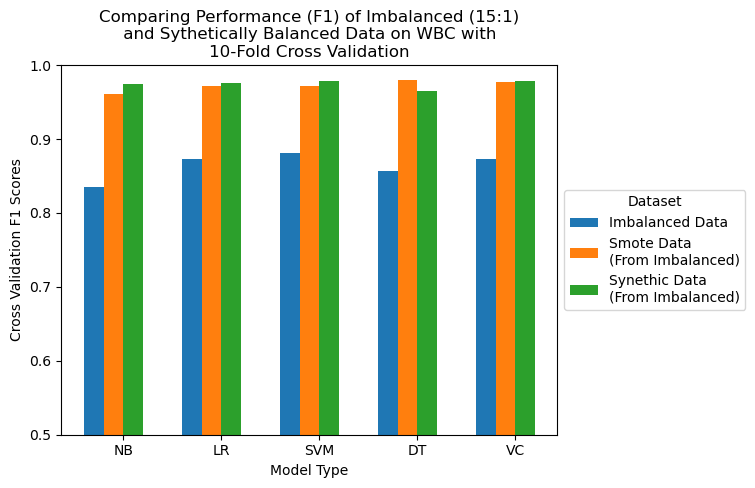

In [6]:
import matplotlib.pyplot as plt 
  
models = ['NB','LR','SVM', 'DT', 'VC' ]


wbc_aug = [np.mean(augNBWBC), np.mean(augLogWBC), np.mean(augSVMWBC),
        np.mean(auglDTWBC), np.mean(augVoteWBC)]
wbc_reg = [np.mean(rawNBWBC), np.mean(rawLogWBC), np.mean(rawSVMWBC),
        np.mean(rawlDTWBC), np.mean(rawVoteWBC)]
wbc_smote = [np.mean(smoteNBWBC), np.mean(smoteLogWBC), np.mean(smoteLogWBC),
        np.mean(smotelDTWBC), np.mean(smoteVoteWBC)]
#over = [np.mean(overNBWBC), np.mean(overLogWBC), np.mean(overSVMWBC),
#        np.mean(overlDTWBC), np.mean(overlDTWBC)]

X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.3, wbc_reg, 0.2, label = 'Imbalanced Data')
#plt.bar(X_axis - 0.1, over, 0.2, label = 'Oversampled Data\n(From Imbalanced)')
plt.bar(X_axis - 0.1, wbc_smote, 0.2, label = 'Smote Data\n(From Imbalanced)')
plt.bar(X_axis + 0.1, wbc_aug, 0.2, label = 'Synethic Data\n(From Imbalanced)')
  
plt.xticks(X_axis, models)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation F1 Scores")
plt.ylim(0.5,1)
plt.title("Comparing Performance (F1) of Imbalanced (15:1)\n and Sythetically Balanced Data on WBC with \n10-Fold Cross Validation")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:

random.seed(42)
np.random.seed(42)
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.float)

X = df[cols[2:]]
y = df[cols[1]]

subSample = pd.DataFrame(subsample(X, y, 20000, 46))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
numClassSamples = len(y) - sum(y)

finalDataset = generateSupplementalData(X, y,  numBenign = numClassSamples, numMalig = numClassSamples)
X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]

augNBWDBC, augLogWDBC, augSVMWDBC, auglDTWDBC, augVoteWDBC = trainF1CrossValModels(X, y, 10)
printOutputs(augNBWDBC, augLogWDBC, augSVMWDBC, auglDTWDBC, augVoteWDBC)

(569, 32)
Final Dataset Composition: (714, 31)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 357
 - Malignant:
   -   New Malignant Instances Created: 311
   -   Old Malignant Instances Used: 46
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.9808963640171434
LR Mean Scores: 0.9241924440484821
SVM Mean Scores: 0.9776771957933825
DT Mean Scores: 0.9621322769317191
VC Mean Scores: 0.9787083829161188


In [8]:
random.seed(42)
np.random.seed(42)
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.float)

X = df[cols[2:]]
y = df[cols[1]]

subSample = pd.DataFrame(subsample(X, y, 20000, 46))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
numClassSamples = len(y) - sum(y)

nbWDBC, lrWDBC, svmWDBC, dtWDBC, vcWDBC = trainF1CrossValModels(X, y, 10)
printOutputs(nbWDBC, lrWDBC, svmWDBC, dtWDBC, vcWDBC)


(569, 32)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.8101587301587301
LR Mean Scores: 0.8546031746031746
SVM Mean Scores: 0.9162698412698413
DT Mean Scores: 0.8480824730824731
VC Mean Scores: 0.8880952380952379


In [9]:
random.seed(42)
np.random.seed(42)
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.float)

X = df[cols[2:]]
y = df[cols[1]]
print('Percent Malignant: {}'.format(sum(y)/len(y)))
subSample = pd.DataFrame(subsample(X, y, 20000, 46))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
print('Percent Malignant: {}'.format(sum(y)/len(y)))
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
print('Percent Malignant: {}'.format(sum(y)/len(y)))

smoteNBWDBC, smoteLogWDBC, smoteSVMWDBC, smotelDTWDBC, smoteVoteWDBC = trainF1CrossValModels(X, y, 10)
printOutputs(smoteNBWDBC, smoteLogWDBC, smoteSVMWDBC, smotelDTWDBC, smoteVoteWDBC)



(569, 32)
Percent Malignant: 0.37258347978910367
Percent Malignant: 0.1141439205955335
Percent Malignant: 0.5
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.9263948597245442
LR Mean Scores: 0.9675716136021929
SVM Mean Scores: 0.9716494982147298
DT Mean Scores: 0.9834708708874249
VC Mean Scores: 0.9681615397192441


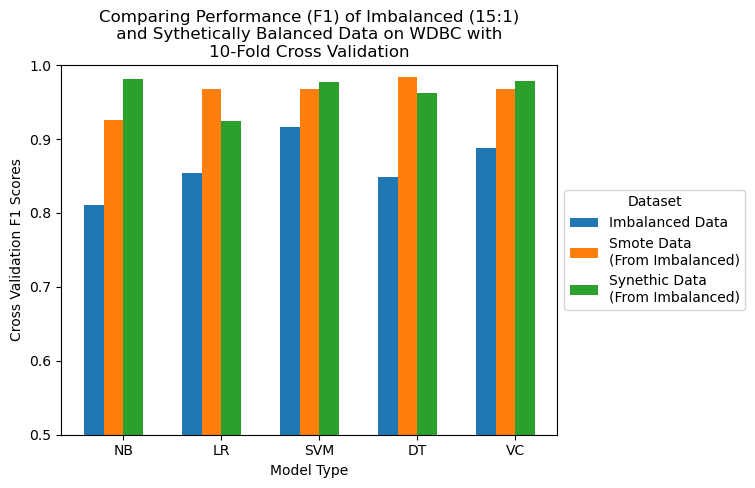

In [10]:
import matplotlib.pyplot as plt 
  
models = ['NB','LR','SVM', 'DT', 'VC' ]
  
aug = [np.mean(augNBWDBC), np.mean(augLogWDBC),
        np.mean(augSVMWDBC), np.mean(auglDTWDBC), np.mean(augVoteWDBC)]
reg = [np.mean(nbWDBC), np.mean(lrWDBC),
        np.mean(svmWDBC), np.mean(dtWDBC), np.mean(vcWDBC)]
smote = [np.mean(smoteNBWDBC), np.mean(smoteLogWDBC), np.mean(smoteLogWDBC),
        np.mean(smotelDTWDBC), np.mean(smoteVoteWDBC)]

X_axis = np.arange(len(models))

plt.bar(X_axis - 0.3, reg, 0.2, label = 'Imbalanced Data')
#plt.bar(X_axis - 0.1, over, 0.2, label = 'Oversampled Data\n(From Imbalanced)')
plt.bar(X_axis - 0.1, smote, 0.2, label = 'Smote Data\n(From Imbalanced)')
plt.bar(X_axis + 0.1, aug, 0.2, label = 'Synethic Data\n(From Imbalanced)')

plt.xticks(X_axis, models)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation F1 Scores")
plt.ylim(0.5,1)
plt.title("Comparing Performance (F1) of Imbalanced (15:1)\n and Sythetically Balanced Data on WDBC with \n10-Fold Cross Validation")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [11]:
random.seed(42)
np.random.seed(42)
cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Diagnosis']
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)
X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]
nullFillNB, nullFillLog, nullFillSVM, nullFillDT, nullFillVote = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(nullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(nullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(nullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(nullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(nullFillVote)))


Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.12710098620088256
LR Mean Scores: 0.0
SVM Mean Scores: 0.0
DT Mean Scores: 0.11089444723177393
VC Mean Scores: 0.0


In [12]:
random.seed(42)
np.random.seed(42)
cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Diagnosis']
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)
X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]
numClassSamples = int(max((len(y) - sum(y)), sum(y)))
finalDataset = generateSupplementalData(X, y, numBenign = numClassSamples, numMalig = numClassSamples)
X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]
print(X.shape)

balNullFillNB, balNullFillLog, balNullFillSVM, balNullFillDT, balNullFillVote = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(balNullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(balNullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(balNullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(balNullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(balNullFillVote)))

Final Dataset Composition: (1606, 29)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 803
 - Malignant:
   -   New Malignant Instances Created: 748
   -   Old Malignant Instances Used: 55
(1606, 28)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.6733211227644904
LR Mean Scores: 0.7504828623918401
SVM Mean Scores: 0.7447786311052548
DT Mean Scores: 0.9153688283574841
VC Mean Scores: 0.7898944634320213


In [13]:
random.seed(42)
np.random.seed(42)
cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Diagnosis']
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)
print(cervical_df.shape)
X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]
numClassSamples = int(max((len(y) - sum(y)), sum(y)))
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
smoteNullFillNB, smoteNullFillLog, smoteNullFillSVM, smoteNullFillDT, smoteNullFillVote = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(smoteNullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(smoteNullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(smoteNullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(smoteNullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(smoteNullFillVote)))

(858, 36)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.6838846261142348
LR Mean Scores: 0.6418827146774897
SVM Mean Scores: 0.6381420039421042
DT Mean Scores: 0.8955158366746241
VC Mean Scores: 0.675551991028348


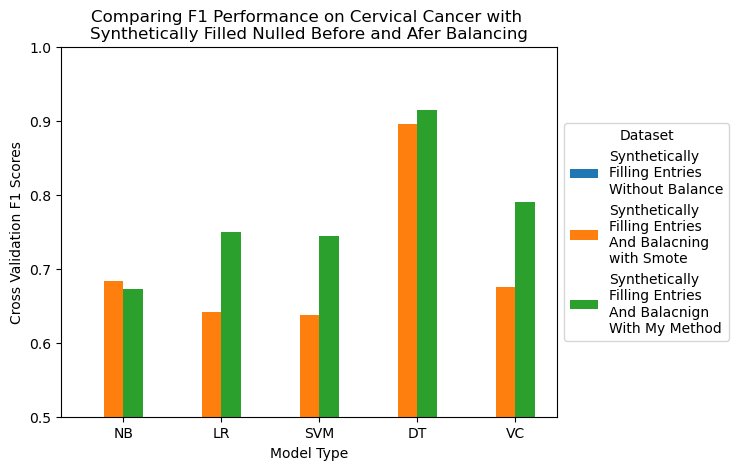

In [14]:
X_Vals = ['NB','LR','SVM', 'DT', 'VC' ]

bal = [np.mean(balNullFillNB), np.mean(balNullFillLog), np.mean(balNullFillSVM),
        np.mean(balNullFillDT), np.mean(balNullFillVote)]
imBal = [np.mean(nullFillNB), np.mean(nullFillLog), np.mean(nullFillSVM),
        np.mean(nullFillDT), np.mean(nullFillVote)]
smoteBal = [np.mean(smoteNullFillNB), np.mean(smoteNullFillLog), np.mean(smoteNullFillSVM),
        np.mean(smoteNullFillDT), np.mean(smoteNullFillVote)]
Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X_Vals))

plt.bar(X_axis - 0.3, imBal, 0.2, label = 'Synthetically\nFilling Entries\nWithout Balance')
#plt.bar(X_axis - 0.1, over, 0.2, label = 'Oversampled Data\n(From Imbalanced)')
plt.bar(X_axis - 0.1, smoteBal, 0.2, label = 'Synthetically\nFilling Entries\nAnd Balacning\nwith Smote')
plt.bar(X_axis + 0.1, bal, 0.2, label = 'Synthetically\nFilling Entries\nAnd Balacnign\nWith My Method')
  
plt.xticks(X_axis, X_Vals)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation F1 Scores")
plt.ylim(0.5,1)
plt.title("Comparing F1 Performance on Cervical Cancer with \nSynthetically Filled Nulled Before and Afer Balancing")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:

random.seed(42)
np.random.seed(42)
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})

colsInUse = ['ID', 'Diagnosis', 'texture', 'smoothness', 'symmetry', 'fractal_dimension', 
                'radius_SE', 'texture_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
                'texture_MAX', 'perimeter_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']

df = df[colsInUse]
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.float)

X = df[colsInUse[2:]]
y = df[colsInUse[1]]

subSample = pd.DataFrame(subsample(X, y, 20000, 46))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
numClassSamples = len(y) - sum(y)

finalDataset = generateSupplementalData(X, y,  numBenign = numClassSamples, numMalig = numClassSamples)
X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]

augNbWDBC_Stripped, augLrWDBC_Stripped, augSvmWDBC_Stripped, augDtWDBC_Stripped, augVcWDBC_Stripped = trainF1CrossValModels(X, y, 10)
print('NB Mean Scores: {}'.format(np.mean(augNbWDBC_Stripped)))
print('LR Mean Scores: {}'.format(np.mean(augLrWDBC_Stripped)))
print('SVM Mean Scores: {}'.format(np.mean(augSvmWDBC_Stripped)))
print('DT Mean Scores: {}'.format(np.mean(augDtWDBC_Stripped)))
print('VC Mean Scores: {}'.format(np.mean(augVcWDBC_Stripped)))


(569, 22)
Final Dataset Composition: (714, 21)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 357
 - Malignant:
   -   New Malignant Instances Created: 311
   -   Old Malignant Instances Used: 46
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.9701477832512315
LR Mean Scores: 0.9706904134089163
SVM Mean Scores: 0.9695087957503548
DT Mean Scores: 0.962300993241703
VC Mean Scores: 0.9630533415568522


In [16]:

random.seed(42)
np.random.seed(42)
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})

colsInUse = ['ID', 'Diagnosis', 'texture', 'smoothness', 'symmetry', 'fractal_dimension', 
                'radius_SE', 'texture_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
                'texture_MAX', 'perimeter_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']

df = df[colsInUse]
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.float)

X = df[colsInUse[2:]]
y = df[colsInUse[1]]

subSample = pd.DataFrame(subsample(X, y, 20000, 46))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]

NbWDBC_Stripped, LrWDBC_Stripped, SvmWDBC_Stripped, DtWDBC_Stripped, VcWDBC_Stripped = trainF1CrossValModels(X, y, 10)
print('NB Mean Scores: {}'.format(np.mean(NbWDBC_Stripped)))
print('LR Mean Scores: {}'.format(np.mean(LrWDBC_Stripped)))
print('SVM Mean Scores: {}'.format(np.mean(SvmWDBC_Stripped)))
print('DT Mean Scores: {}'.format(np.mean(DtWDBC_Stripped)))
print('VC Mean Scores: {}'.format(np.mean(VcWDBC_Stripped)))


(569, 22)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.6718253968253969
LR Mean Scores: 0.887936507936508
SVM Mean Scores: 0.8962698412698412
DT Mean Scores: 0.8143523143523144
VC Mean Scores: 0.8613492063492064


In [17]:
random.seed(42)
np.random.seed(42)
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})

colsInUse = ['ID', 'Diagnosis', 'texture', 'smoothness', 'symmetry', 'fractal_dimension', 
                'radius_SE', 'texture_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
                'texture_MAX', 'perimeter_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']

df = df[colsInUse]
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.float)

X = df[colsInUse[2:]]
y = df[colsInUse[1]]

subSample = pd.DataFrame(subsample(X, y, 20000, 46))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
smoteNbWDBC_Stripped, smoteLrWDBC_Stripped, smoteSvmWDBC_Stripped, smoteDtWDBC_Stripped, smoteVcWDBC_Stripped = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(smoteNbWDBC_Stripped)))
print('LR Mean Scores: {}'.format(np.mean(smoteLrWDBC_Stripped)))
print('SVM Mean Scores: {}'.format(np.mean(smoteSvmWDBC_Stripped)))
print('DT Mean Scores: {}'.format(np.mean(smoteDtWDBC_Stripped)))
print('VC Mean Scores: {}'.format(np.mean(smoteVcWDBC_Stripped)))

(569, 22)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.847999127717553
LR Mean Scores: 0.9621144636330989
SVM Mean Scores: 0.9599678535848876
DT Mean Scores: 0.9753388445362206
VC Mean Scores: 0.9671437677907357


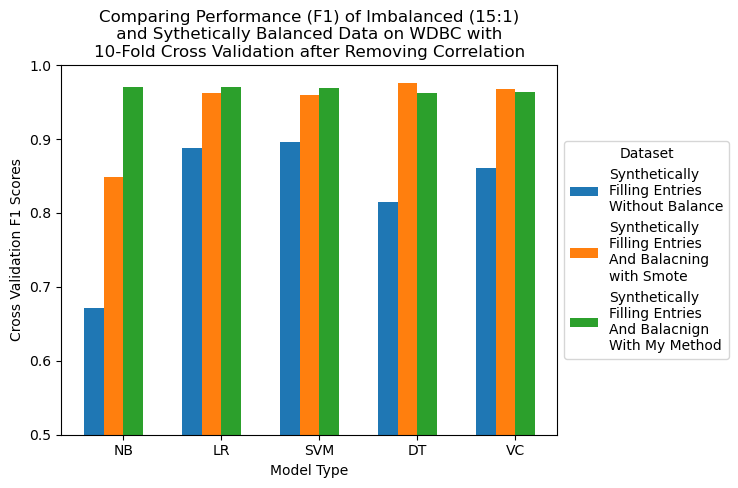

In [18]:
X_Vals = ['NB','LR','SVM', 'DT', 'VC' ]

imbal = [np.mean(NbWDBC_Stripped), np.mean(LrWDBC_Stripped), np.mean(SvmWDBC_Stripped),
        np.mean(DtWDBC_Stripped), np.mean(VcWDBC_Stripped)]
bal = [np.mean(augNbWDBC_Stripped), np.mean(augLrWDBC_Stripped), np.mean(augSvmWDBC_Stripped),
        np.mean(augDtWDBC_Stripped), np.mean(augVcWDBC_Stripped)]
smoteBal = [np.mean(smoteNbWDBC_Stripped), np.mean(smoteLrWDBC_Stripped), np.mean(smoteSvmWDBC_Stripped),
        np.mean(smoteDtWDBC_Stripped), np.mean(smoteVcWDBC_Stripped)]

X_axis = np.arange(len(X_Vals))



plt.bar(X_axis - 0.3, imbal, 0.2, label = 'Synthetically\nFilling Entries\nWithout Balance')
#plt.bar(X_axis - 0.1, over, 0.2, label = 'Oversampled Data\n(From Imbalanced)')
plt.bar(X_axis - 0.1, smoteBal, 0.2, label = 'Synthetically\nFilling Entries\nAnd Balacning\nwith Smote')
plt.bar(X_axis + 0.1, bal, 0.2, label = 'Synthetically\nFilling Entries\nAnd Balacnign\nWith My Method')
  
plt.xticks(X_axis, X_Vals)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation F1 Scores")
plt.ylim(0.5,1)
plt.title("Comparing Performance (F1) of Imbalanced (15:1)\n and Sythetically Balanced Data on WDBC with \n10-Fold Cross Validation after Removing Correlation")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [19]:
random.seed(42)
np.random.seed(42)
surgicalDF = pd.read_csv('Surgical-deepnet.csv')
surgicalDF.rename(columns = {'complication':'Diagnosis'}, inplace = True)
for i in surgicalDF:
    surgicalDF[i] = surgicalDF[i].astype(np.float)
print('Num Samples: {}, Num Positive: {}'.format(len(surgicalDF['Diagnosis']), sum(surgicalDF['Diagnosis'])))
X = surgicalDF[surgicalDF.columns[:-1]]
y = surgicalDF[surgicalDF.columns[-1]]
subSample = pd.DataFrame(subsample(X, y, 5000, 666))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
print('Num Samples: {}, Num Positive: {}'.format(len(y), sum(y)))

nbImmuno, lrImmuno, svmImmuno, dtImmuno, vcImmuno = trainF1CrossValModels(X, y, 10)
print('NB Mean Scores: {}'.format(np.mean(nbImmuno)))
print('LR Mean Scores: {}'.format(np.mean(lrImmuno)))
print('SVM Mean Scores: {}'.format(np.mean(svmImmuno)))
print('DT Mean Scores: {}'.format(np.mean(dtImmuno)))
print('VC Mean Scores: {}'.format(np.mean(vcImmuno)))

Num Samples: 14635, Num Positive: 3690.0
Num Samples: 5666, Num Positive: 666
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.623370036129982
LR Mean Scores: 0.7089621398119368
SVM Mean Scores: 0.83192012044801
DT Mean Scores: 0.6826328629490956
VC Mean Scores: 0.7803112845598337


In [20]:
# Takes about 4:30 to run
random.seed(42)
np.random.seed(42)
surgicalDF = pd.read_csv('Surgical-deepnet.csv')
surgicalDF.rename(columns = {'complication':'Diagnosis'}, inplace = True)
for i in surgicalDF:
    surgicalDF[i] = surgicalDF[i].astype(np.float)
print('Num Samples: {}, Num Positive: {}'.format(len(surgicalDF['Diagnosis']), sum(surgicalDF['Diagnosis'])))
X = surgicalDF[surgicalDF.columns[:-1]]
y = surgicalDF[surgicalDF.columns[-1]]

subSample = pd.DataFrame(subsample(X, y, 5000, 666))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
print('Num Samples: {}, Num Positive: {}'.format(len(y), sum(y)))
numClassSamples = len(y) - sum(y)

finalDataset = generateSupplementalData(X, y,  numBenign = numClassSamples, numMalig = numClassSamples)
X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]
print('Num Samples: {}, Num Positive: {}'.format(len(y), sum(y)))

augNbImmuno, augLogImmuno, augSvmImmuno, auglDtImmuno, augVoteImmuno = trainF1CrossValModels(X, y, 10)
print('NB Mean Scores: {}'.format(np.mean(augNbImmuno)))
print('LR Mean Scores: {}'.format(np.mean(augLogImmuno)))
print('SVM Mean Scores: {}'.format(np.mean(augSvmImmuno)))
print('DT Mean Scores: {}'.format(np.mean(auglDtImmuno)))
print('VC Mean Scores: {}'.format(np.mean(augVoteImmuno)))

Num Samples: 14635, Num Positive: 3690.0
Num Samples: 5666, Num Positive: 666
Final Dataset Composition: (10000, 25)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 5000
 - Malignant:
   -   New Malignant Instances Created: 4334
   -   Old Malignant Instances Used: 666
Num Samples: 10000, Num Positive: 5000.0
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.8720610707346548
LR Mean Scores: 0.8804526665035807
SVM Mean Scores: 0.9159206582083961
DT Mean Scores: 0.9413918375514152
VC Mean Scores: 0.9121203721253173


In [21]:
# Takes about 4:30 to run
random.seed(42)
np.random.seed(42)
surgicalDF = pd.read_csv('Surgical-deepnet.csv')
surgicalDF.rename(columns = {'complication':'Diagnosis'}, inplace = True)
for i in surgicalDF:
    surgicalDF[i] = surgicalDF[i].astype(np.float)
print('Num Samples: {}, Num Positive: {}'.format(len(surgicalDF['Diagnosis']), sum(surgicalDF['Diagnosis'])))
X = surgicalDF[surgicalDF.columns[:-1]]
y = surgicalDF[surgicalDF.columns[-1]]

subSample = pd.DataFrame(subsample(X, y, 5000, 666))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
print('Num Samples: {}, Num Positive: {}'.format(len(y), sum(y)))
numClassSamples = len(y) - sum(y)
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
print('Num Samples: {}, Num Positive: {}'.format(len(y), sum(y)))

smoteNbImmuno, smoteLogImmuno, smoteSvmImmuno, smoteDtImmuno, smoteVoteImmuno = trainF1CrossValModels(X, y, 10)
print('NB Mean Scores: {}'.format(np.mean(smoteNbImmuno)))
print('LR Mean Scores: {}'.format(np.mean(smoteLogImmuno)))
print('SVM Mean Scores: {}'.format(np.mean(smoteSvmImmuno)))
print('DT Mean Scores: {}'.format(np.mean(smoteDtImmuno)))
print('VC Mean Scores: {}'.format(np.mean(smoteVoteImmuno)))

Num Samples: 14635, Num Positive: 3690.0
Num Samples: 5666, Num Positive: 666
Num Samples: 10000, Num Positive: 5000
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.8755098748467249
LR Mean Scores: 0.880946304649529
SVM Mean Scores: 0.9008686132602179
DT Mean Scores: 0.9360921388421215
VC Mean Scores: 0.9048825048120316


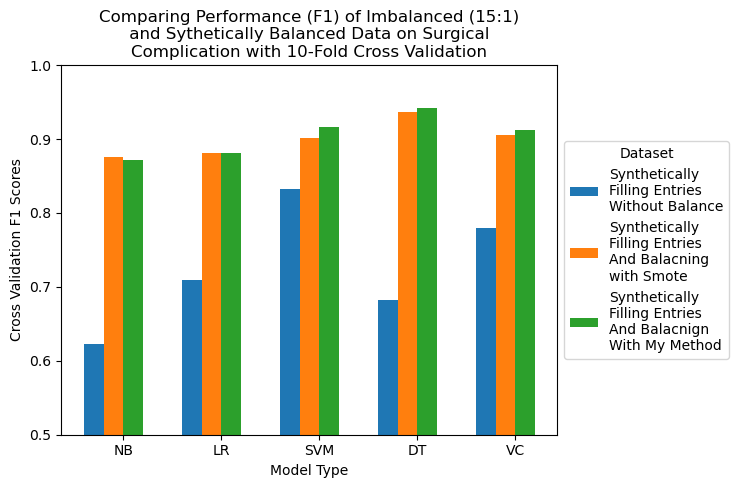

In [22]:
X_Vals = ['NB','LR','SVM', 'DT', 'VC' ]

imbal = [np.mean(nbImmuno), np.mean(lrImmuno), np.mean(svmImmuno),
        np.mean(dtImmuno), np.mean(vcImmuno)]
bal = [np.mean(augNbImmuno), np.mean(augLogImmuno), np.mean(augSvmImmuno),
        np.mean(auglDtImmuno), np.mean(augVoteImmuno)]
smoteBal = [np.mean(smoteNbImmuno), np.mean(smoteLogImmuno), np.mean(smoteSvmImmuno),
        np.mean(smoteDtImmuno), np.mean(smoteVoteImmuno)]

X_axis = np.arange(len(X_Vals))

plt.bar(X_axis - 0.3, imbal, 0.2, label = 'Synthetically\nFilling Entries\nWithout Balance')
#plt.bar(X_axis - 0.1, over, 0.2, label = 'Oversampled Data\n(From Imbalanced)')
plt.bar(X_axis - 0.1, smoteBal, 0.2, label = 'Synthetically\nFilling Entries\nAnd Balacning\nwith Smote')
plt.bar(X_axis + 0.1, bal, 0.2, label = 'Synthetically\nFilling Entries\nAnd Balacnign\nWith My Method')
  
plt.xticks(X_axis, X_Vals)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation F1 Scores")
plt.ylim(0.5,1)
plt.title("Comparing Performance (F1) of Imbalanced (15:1)\n and Sythetically Balanced Data on Surgical \nComplication with 10-Fold Cross Validation")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [23]:
wbc_aug = [np.mean(augNBWBC), np.mean(augLogWBC), np.mean(augSVMWBC),
        np.mean(auglDTWBC), np.mean(augVoteWBC)]
wbc_reg = [np.mean(rawNBWBC), np.mean(rawLogWBC), np.mean(rawSVMWBC),
        np.mean(rawlDTWBC), np.mean(rawVoteWBC)]
wbc_smote = [np.mean(smoteNBWBC), np.mean(smoteLogWBC), np.mean(smoteSVMWBC),
        np.mean(smotelDTWBC), np.mean(smoteVoteWBC)]


wdbc_aug = [np.mean(augNBWDBC), np.mean(augLogWDBC),
        np.mean(augSVMWDBC), np.mean(auglDTWDBC), np.mean(augVoteWDBC)]
wdbc_reg = [np.mean(nbWDBC), np.mean(lrWDBC),
        np.mean(svmWDBC), np.mean(dtWDBC), np.mean(vcWDBC)]
wdbc_smote = [np.mean(smoteNBWDBC), np.mean(smoteLogWDBC), np.mean(smoteLogWDBC),
        np.mean(smotelDTWDBC), np.mean(smoteVoteWDBC)]


wdbc_stripped_imbal = [np.mean(NbWDBC_Stripped), np.mean(LrWDBC_Stripped), np.mean(SvmWDBC_Stripped),
        np.mean(DtWDBC_Stripped), np.mean(VcWDBC_Stripped)]
wdbc_stripped_bal = [np.mean(augNbWDBC_Stripped), np.mean(augLrWDBC_Stripped), np.mean(augSvmWDBC_Stripped),
        np.mean(augDtWDBC_Stripped), np.mean(augVcWDBC_Stripped)]
wdbc_stripped_smoteBal = [np.mean(smoteNbWDBC_Stripped), np.mean(smoteLrWDBC_Stripped), np.mean(smoteSvmWDBC_Stripped),
        np.mean(smoteDtWDBC_Stripped), np.mean(smoteVcWDBC_Stripped)]


immuno_imbal = [np.mean(nbImmuno), np.mean(lrImmuno), np.mean(svmImmuno),
        np.mean(dtImmuno), np.mean(vcImmuno)]
immuno_bal = [np.mean(augNbImmuno), np.mean(augLogImmuno), np.mean(augSvmImmuno),
        np.mean(auglDtImmuno), np.mean(augVoteImmuno)]
immuno_smoteBal = [np.mean(smoteNbImmuno), np.mean(smoteLogImmuno), np.mean(smoteSvmImmuno),
        np.mean(smoteDtImmuno), np.mean(smoteVoteImmuno)]

X_vals = ['NB','LR','SVM', 'DT', 'VC']
X_axis = np.arange(len(X_Vals))


In [24]:
def compareResults(firstSet, firstName, secondSet, secondName):
    firstSet, secondSet = np.array(firstSet), np.array(secondSet)
    print('{} Scores: {}'.format(firstName, firstSet))
    print('{} Scores: {}'.format(secondName, secondSet))
    print('{} - {}: {}'.format(firstName, secondName, firstSet - secondSet))
    print('Mean Difference: {}'.format(np.mean(firstSet - secondSet)))
    print('Number of {} Dominant Scores: {}'.format(firstName, sum((firstSet - secondSet) > 0)))
    print('Number of {} Dominant Scores: {}'.format(secondName, sum((firstSet - secondSet) < 0)))
    firstSet_withoutDT = np.delete(firstSet, 3)
    secondSet_withoutDT = np.delete(secondSet, 3)
    print(firstSet_withoutDT)
    print(secondSet_withoutDT)
    print('{} - {} (Without DT): {}'.format(firstName, secondName, firstSet_withoutDT - secondSet_withoutDT))
    print('Mean Difference (Without DT): {}'.format(np.mean(firstSet_withoutDT - secondSet_withoutDT)))


compareResults(wbc_aug, 'AUG', wbc_reg, 'REG')
print('-'*30)
compareResults(wdbc_aug, 'AUG', wdbc_reg, 'REG')
print('-'*30)
compareResults(wdbc_stripped_bal, 'AUG', wdbc_stripped_imbal, 'REG')
print('-'*30)
compareResults(immuno_bal, 'AUG', immuno_imbal, 'REG')

print((('-' * 30) + '\n')*4)

compareResults(wbc_aug, 'AUG', wbc_smote, 'SMOTE')
print('-'*60)
compareResults(wdbc_aug, 'AUG', wdbc_smote, 'SMOTE')
print('-'*30)
compareResults(wdbc_stripped_bal, 'AUG', wdbc_stripped_smoteBal, 'SMOTE')
print('-'*30)
compareResults(immuno_bal, 'AUG', immuno_smoteBal, 'SMOTE')

AUG Scores: [0.97495586 0.97636065 0.97894608 0.96503052 0.97863339]
REG Scores: [0.8352952  0.87271562 0.88150683 0.85707459 0.87271562]
AUG - REG: [0.13966066 0.10364503 0.09743925 0.10795593 0.10591778]
Mean Difference: 0.11092373028820361
Number of AUG Dominant Scores: 5
Number of REG Dominant Scores: 0
[0.97495586 0.97636065 0.97894608 0.97863339]
[0.8352952  0.87271562 0.88150683 0.87271562]
AUG - REG (Without DT): [0.13966066 0.10364503 0.09743925 0.10591778]
Mean Difference (Without DT): 0.11166567983226888
------------------------------
AUG Scores: [0.98089636 0.92419244 0.9776772  0.96213228 0.97870838]
REG Scores: [0.81015873 0.85460317 0.91626984 0.84808247 0.88809524]
AUG - REG: [0.17073763 0.06958927 0.06140735 0.1140498  0.09061314]
Mean Difference: 0.10127944129947779
Number of AUG Dominant Scores: 5
Number of REG Dominant Scores: 0
[0.98089636 0.92419244 0.9776772  0.97870838]
[0.81015873 0.85460317 0.91626984 0.88809524]
AUG - REG (Without DT): [0.17073763 0.06958927 

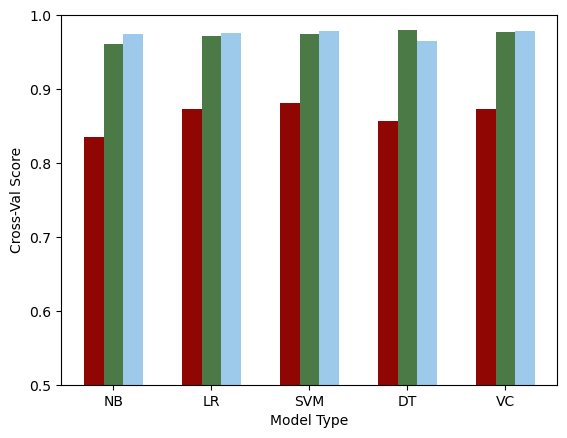

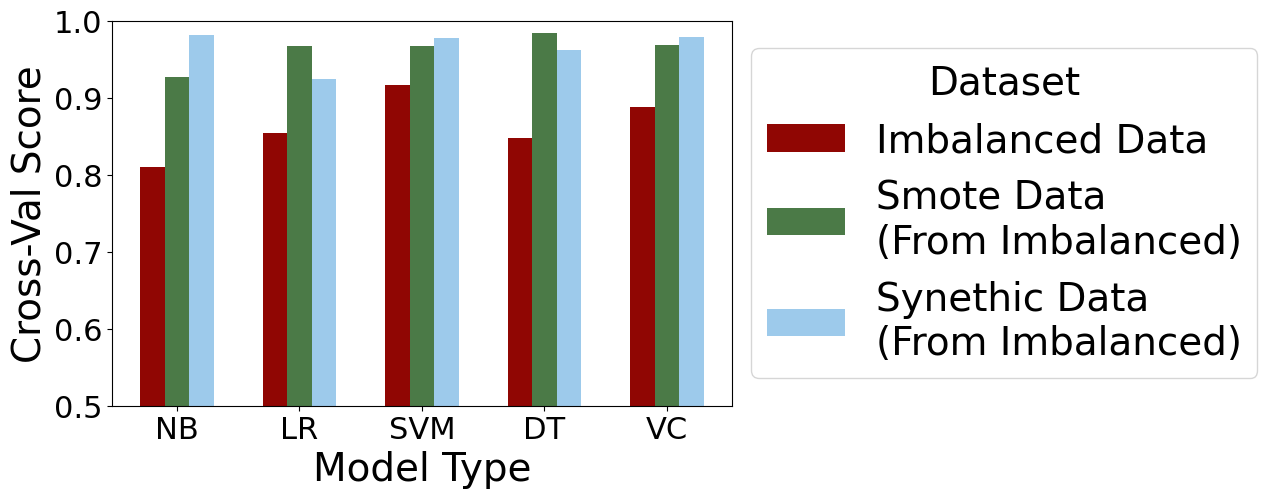

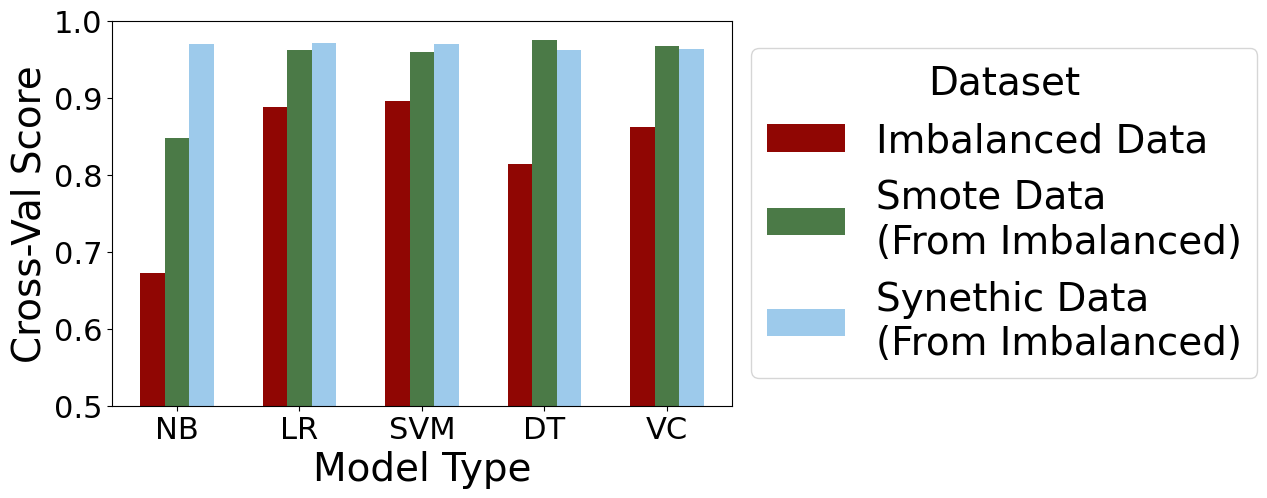

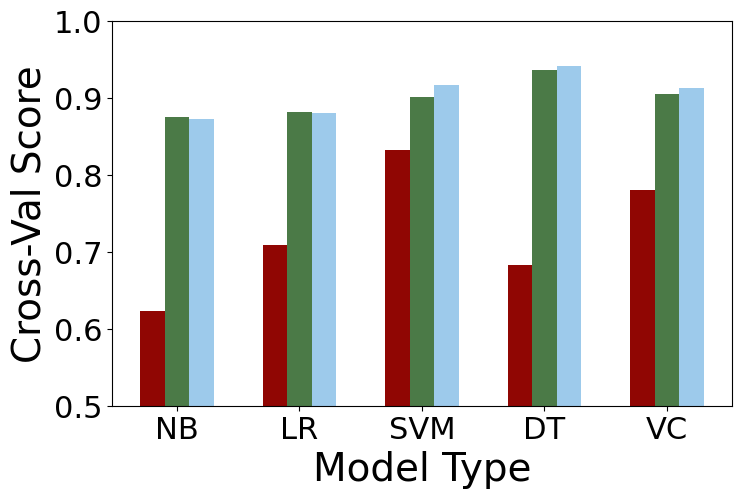

In [25]:
plt.bar(X_axis - 0.2, wbc_reg, 0.2, label = 'Imbalanced Data', color='#900603')
plt.bar(X_axis - 0.0, wbc_smote, 0.2, label = 'Smote Data\n(From Imbalanced)', color='#4B7A47')
plt.bar(X_axis + 0.2, wbc_aug, 0.2, label = 'Synethic Data\n(From Imbalanced)', color='#9DCAEB')
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross-Val Score")
plt.ylim(0.5,1)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 28})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.show()


plt.bar(X_axis - 0.2, wdbc_reg, 0.2, label = 'Imbalanced Data', color='#900603')
plt.bar(X_axis - 0.0, wdbc_smote, 0.2, label = 'Smote Data\n(From Imbalanced)', color='#4B7A47')
plt.bar(X_axis + 0.2, wdbc_aug, 0.2, label = 'Synethic Data\n(From Imbalanced)', color='#9DCAEB')
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross-Val Score")
plt.ylim(0.5,1)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 28})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


plt.bar(X_axis - 0.2, wdbc_stripped_imbal, 0.2, label = 'Imbalanced Data', color='#900603')
plt.bar(X_axis - 0.0, wdbc_stripped_smoteBal, 0.2, label = 'Smote Data\n(From Imbalanced)', color='#4B7A47')
plt.bar(X_axis + 0.2, wdbc_stripped_bal, 0.2, label = 'Synethic Data\n(From Imbalanced)', color='#9DCAEB')
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross-Val Score")
plt.ylim(0.5,1)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 28})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


plt.bar(X_axis - 0.2, immuno_imbal, 0.2, label = 'Imbalanced Data', color='#900603')
plt.bar(X_axis - 0.0, immuno_smoteBal, 0.2, label = 'Smote Data\n(From Imbalanced)', color='#4B7A47')
plt.bar(X_axis + 0.2, immuno_bal, 0.2, label = 'Synethic Data\n(From Imbalanced)', color='#9DCAEB')
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross-Val Score")
plt.ylim(0.5,1)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 28})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.show()
